# Examples of Metropolis-adjusted Langevin algorithm (MALA) working well

This notebook shows some examples where Langevin Monte Carlo (LMC) does not work well while Metropolis-adjusted Langevin algorithm (MALA) works well.

In [1]:
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import gamma
from ssbgm.math import langevin_montecarlo
from ssbgm.model import ScoreBasedGenerator

np.random.seed(42)

## Example 1: $p(x) \propto \exp(-x^4)$

Let's consider the distribution $p(x) \propto \exp(-x^4)$.

In this case, Langevin Monte Carlo is transient, which causes the digergence of a sample path.

Ref. https://ktrmnm.github.io/blog/2016/08/25/201608-lmc/201608_mala.pdf

In [2]:
def pdf1(x):
    return np.exp(-x**4) / (2*gamma(5/4))

def pdf1_(x):
    return np.exp(-x**4)

def nabla_U(x):
    return 4*x**3

x0 = np.zeros((500, 1))

# Without acceptance / rejection
paths_langevin_monte_carlo = langevin_montecarlo(x0=x0, nabla_U=nabla_U, delta_t=0.1, n_steps=256, verbose=True)
# With acceptance / rejection
paths_metropolis_adjusted_langevin_algorithm = langevin_montecarlo(x0=x0, nabla_U=nabla_U, delta_t=0.1, n_steps=256, pdf=pdf1_, verbose=True)

  0%|          | 0/255 [00:00<?, ?it/s]C:\Users\hmasu\AppData\Local\Temp\ipykernel_19556\1103201505.py:8: RuntimeWarning: overflow encountered in power
  return 4*x**3
D:\dev_libs\ssbgm\ssbgm\math.py:79: RuntimeWarning: invalid value encountered in subtract
  return x - nabla_U(x) * delta_t + np.random.randn(*x.shape) * np.sqrt(2*delta_t)  # type: ignore # noqa
100%|██████████| 255/255 [00:03<00:00, 76.47it/s]


Drawing the sample paths of Langevin Monte Carlo, we can see that the sample path diverges.

On the other hand, Metrolis-Adjusted Langevin Algorithm (MALA) works well.

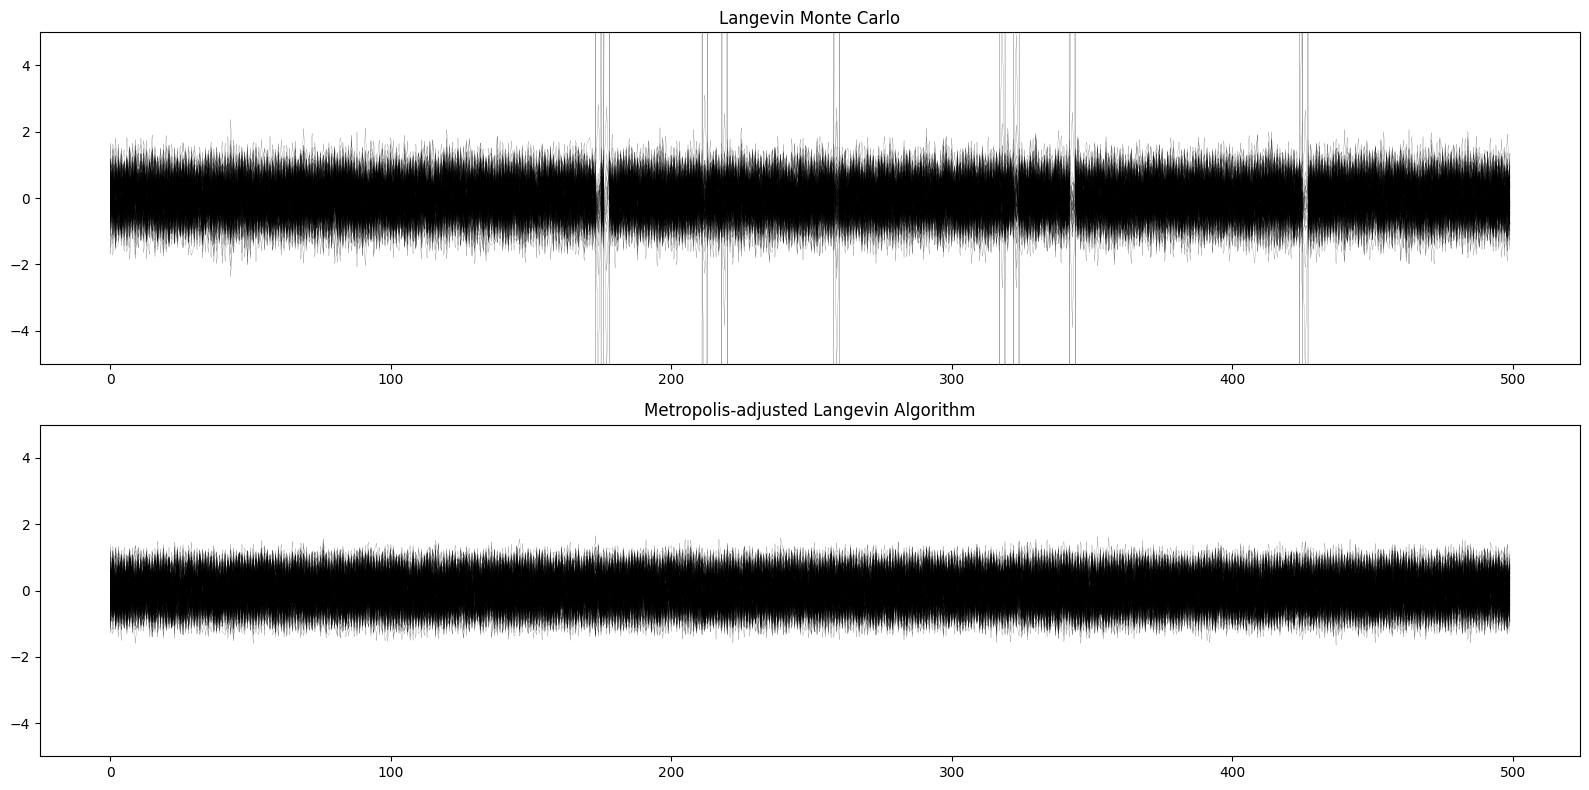

Min/Max of sample paths of Langevin Monte Carlo: nan nan
Min/Max of sample paths Metropolos Adjusted Langevin Algorithm: -1.6525263154822776 1.6583681587412067
Min/Max without NaN of sample paths of Langevin Monte Carlo: -inf inf
Min/Max without NaN of sample paths Metropolos Adjusted Langevin Algorithm: -1.6525263154822776 1.6583681587412067


In [3]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

axs[0].set_title('Langevin Monte Carlo')
for path in paths_langevin_monte_carlo:
    axs[0].plot(path, 'k-', lw=0.1)
axs[0].set_ylim(-5, 5)

axs[1].set_title('Metropolis-adjusted Langevin Algorithm')
for path in paths_metropolis_adjusted_langevin_algorithm:
    axs[1].plot(path, 'k-', lw=0.1)
axs[1].set_ylim(-5, 5)

plt.tight_layout()
plt.show()

print('Min/Max of sample paths of Langevin Monte Carlo:', np.min(paths_langevin_monte_carlo), np.max(paths_langevin_monte_carlo))
print('Min/Max of sample paths Metropolos Adjusted Langevin Algorithm:', np.min(paths_metropolis_adjusted_langevin_algorithm), np.max(paths_metropolis_adjusted_langevin_algorithm))

print('Min/Max without NaN of sample paths of Langevin Monte Carlo:', np.nanmin(paths_langevin_monte_carlo), np.nanmax(paths_langevin_monte_carlo))
print('Min/Max without NaN of sample paths Metropolos Adjusted Langevin Algorithm:', np.nanmin(paths_metropolis_adjusted_langevin_algorithm), np.nanmax(paths_metropolis_adjusted_langevin_algorithm))

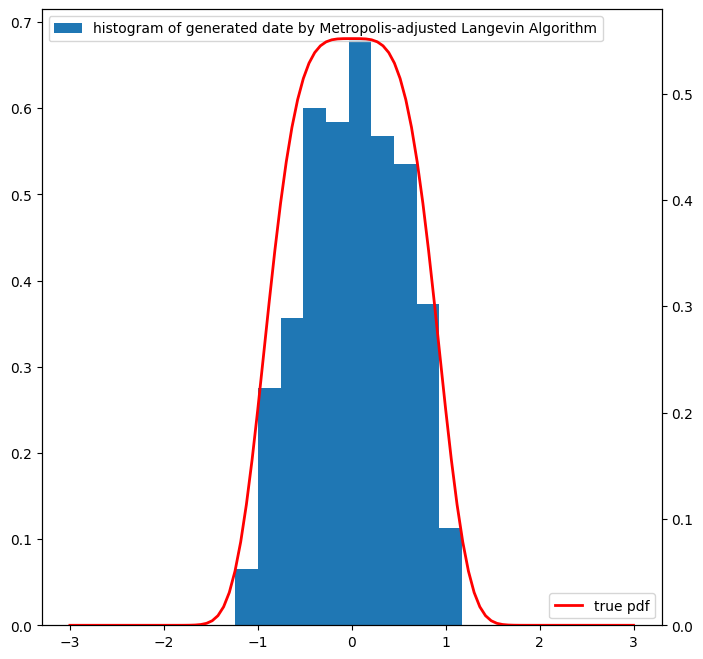

In [4]:
_, ax = plt.subplots(1, 1, figsize=(8, 8))
axd = ax.twinx()
ax.hist(np.hstack([path[-1] for path in paths_metropolis_adjusted_langevin_algorithm]), density=True, label='histogram of generated date by Metropolis-adjusted Langevin Algorithm')
axd.plot(np.linspace(-3, 3, 100), pdf1(np.linspace(-3, 3, 100)), 'r-', lw=2, label='true pdf')
ax.set_ylim(0)
axd.set_ylim(0)
ax.legend(loc='upper left')
axd.legend(loc='lower right')
plt.show()

## Case2: Generate data with Score Based Model for data with a limited range of values

In [5]:
def pdf2(x):
    return (0 <= x) * (x <= 1)

X = np.random.rand(1000)
model = ScoreBasedGenerator(LGBMRegressor(random_state=42), verbose=True)
model.fit(X, noise_strengths=np.sqrt(5*np.logspace(-4, np.log10(X.var()))))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 306
[LightGBM] [Info] Number of data points in the train set: 50000, number of used features: 2
[LightGBM] [Info] Start training from score 0.013361


ScoreBasedGenerator(estimator=LGBMRegressor(random_state=42), verbose=True)

In [6]:
samples_wo_rejection = model.sample(n_samples=1000, init_sample=np.array([X.mean()]), alpha=1e-2, sigma=1e-3).flatten()
samples_w_rejection = model.sample(n_samples=1000, init_sample=np.array([X.mean()]), alpha=1e-2, sigma=1e-3, is_in_valid_domain_func=lambda x: (0 <= x)*(x <= 1)).flatten()

100%|██████████| 999/999 [00:13<00:00, 75.23it/s]


As shown below, samples generated by LMC break out the range of the data, [0, 1].

On the other hand, samples generated by MALA are distributed in [0, 1].

In [7]:
print('Min/Max of samples without rejection:', np.min(samples_wo_rejection), np.max(samples_wo_rejection))
print('Min/Max of samples with rejection:', np.min(samples_w_rejection), np.max(samples_w_rejection))

Min/Max of samples without rejection: -0.22216928933242105 1.2840481301405307
Min/Max of samples with rejection: 0.0015423721880231944 0.9993609959079643


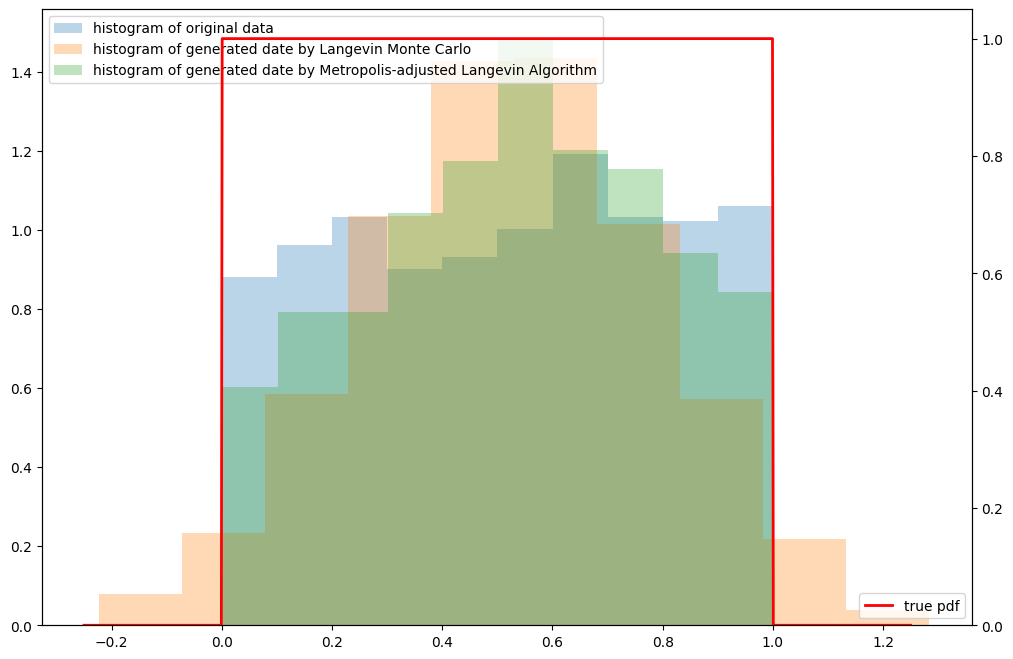

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))
axd = ax.twinx()
ax.hist(X, density=True, label='histogram of original data', alpha=0.3)
ax.hist(samples_wo_rejection, density=True, label='histogram of generated date by Langevin Monte Carlo', alpha=0.3)
ax.hist(samples_w_rejection, density=True, label='histogram of generated date by Metropolis-adjusted Langevin Algorithm', alpha=0.3)
axd.plot(np.linspace(-0.25, 1.25, 1000), pdf2(np.linspace(-0.25, 1.25, 1000)) , 'r-', lw=2, label='true pdf')
axd.set_ylim(0)
ax.legend(loc='upper left')
axd.legend(loc='lower right')
plt.show()